In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout

from tqdm import tqdm
from joblib import dump, load

In [2]:
df = pd.read_csv("heloc_processed.csv")

In [3]:
df = df.drop(df.columns[0], axis=1)

In [4]:
df

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,1,55.0,144.0,2.321928,84,20,2.000000,83,2.0,3,...,1,43,0.000000,0.000000,33.0,NaN,8.0,1.000000,1.0,69.0
1,1,61.0,58.0,4.000000,41,2,2.321928,100,NaN,0,...,0,67,0.000000,0.000000,0.0,NaN,0.0,NaN,NaN,0.0
2,1,67.0,66.0,2.584963,24,9,0.000000,100,NaN,7,...,4,44,0.000000,2.321928,53.0,66.0,4.0,1.584963,1.0,86.0
3,1,66.0,169.0,1.000000,73,28,1.000000,93,76.0,6,...,3,57,0.000000,2.584963,72.0,83.0,6.0,2.321928,2.0,91.0
4,1,81.0,333.0,4.807355,132,12,0.000000,100,NaN,7,...,0,25,0.000000,1.000000,51.0,89.0,3.0,1.000000,0.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9768,0,73.0,131.0,2.584963,57,21,0.000000,95,80.0,6,...,5,19,3.000000,0.000000,26.0,NaN,5.0,1.584963,0.0,100.0
9769,1,65.0,147.0,5.321928,68,11,0.000000,92,28.0,6,...,0,42,1.000000,1.000000,86.0,53.0,2.0,1.584963,1.0,80.0
9770,1,74.0,129.0,2.807355,64,18,1.000000,100,NaN,6,...,1,33,2.000000,2.321928,6.0,NaN,5.0,NaN,0.0,56.0
9771,1,72.0,234.0,3.700440,113,42,1.584963,96,35.0,6,...,0,20,2.807355,0.000000,19.0,NaN,4.0,1.000000,0.0,38.0


## RandomForestClassifier

Progreso: 100%|██████████| 20/20 [02:45<00:00,  8.26s/it]


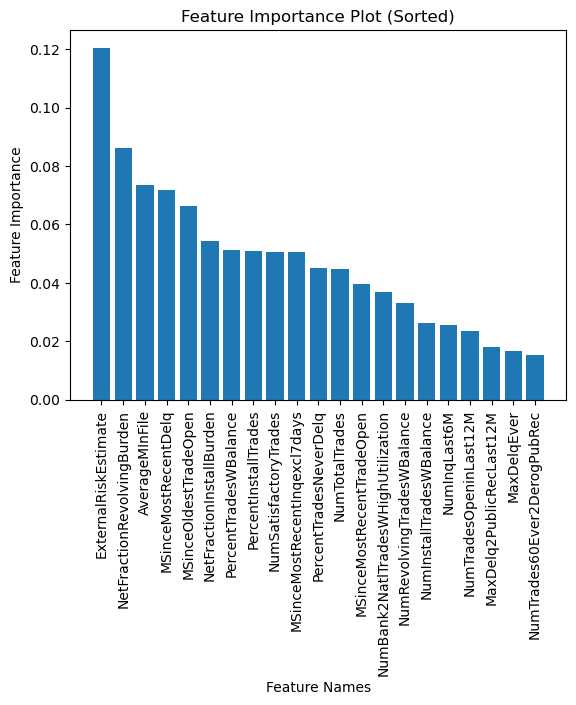

Modelo: RandomForestClassifier(random_state=42)
Vecinos: 7
Precision: 0.7336136059621632
Recall: 0.7558574522543808
F1 Score: 0.7445694336695112
Accuracy: 0.7304819400388827
AUC: 0.7294412953645146
Modelo guardado como 'modelo_rfc.joblib'


In [5]:
best_results = {"Modelo": None, "Precision": 0 ,"Accuracy": 0, "Recall": 0, "F1": 0, "AUC": 0, "Vecinos": 0}

for neighbors in tqdm(range(1, 21), desc="Progreso"):
    imputer = KNNImputer(n_neighbors=neighbors)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    X = df_imputed.drop(["RiskPerformance"], axis=1)
    y = df_imputed["RiskPerformance"]

    model = RandomForestClassifier(random_state=42)

    cv_predictions = cross_val_predict(model, X, y, cv=5)

    avg_precision = precision_score(y, cv_predictions)
    avg_accuracy  = accuracy_score(y, cv_predictions)
    avg_recall    = recall_score(y, cv_predictions)
    avg_auc       = roc_auc_score(y, cv_predictions)
    avg_f1        = f1_score(y, cv_predictions)

    if avg_precision > best_results["Precision"]:
        best_results["Modelo"]    = model
        best_results["Precision"] = avg_precision
        best_results["Accuracy"]  = avg_accuracy
        best_results["Recall"]    = avg_recall
        best_results["F1"]        = avg_f1
        best_results["AUC"]       = avg_auc
        best_results["Vecinos"]   = neighbors
        df_imputer = imputer

df_final = pd.DataFrame(df_imputer.transform(df), columns=df.columns)
best_model = best_results["Modelo"]
best_model.fit(X, y)
feature_importance = best_model.feature_importances_
feature_names = X.columns

feature_importance_sorted = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_feature_importance = zip(*feature_importance_sorted)

plt.bar(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Plot (Sorted)')
plt.xticks(rotation=90)
plt.show()


dump(best_model, 'modelo_rfc.joblib')

print("Modelo:"   , best_results["Modelo"])
print("Vecinos:"  , best_results["Vecinos"])
print("Precision:", best_results["Precision"])
print("Recall:"   , best_results["Recall"])
print("F1 Score:" , best_results["F1"])
print("Accuracy:" , best_results["Accuracy"])
print("AUC:"      , best_results["AUC"])
print("Modelo guardado como 'modelo_rfc.joblib'")

In [6]:
df_final.to_csv('df_final_7k.csv', index=False)

## GradientBoostingClassifier

Progreso: 100%|██████████| 20/20 [02:49<00:00,  8.46s/it]


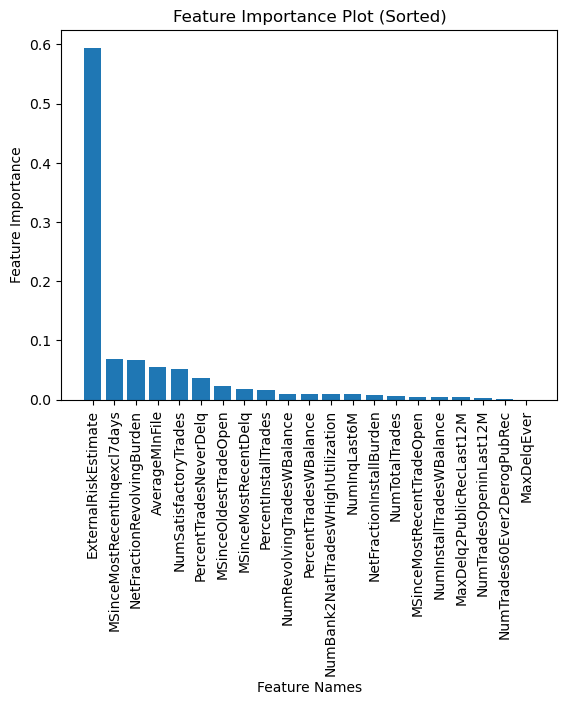

Modelo: GradientBoostingClassifier(random_state=42)
Vecinos: 6
Precision: 0.7364008578670306
Recall: 0.7436503248670998
F1 Score: 0.7400078369905956
Accuracy: 0.7284354855213343
AUC: 0.7278115280066219
Modelo guardado como 'modelo_gbc.joblib'


In [7]:
best_results = {"Modelo": None, "Precision": 0 ,"Accuracy": 0, "Recall": 0, "F1": 0, "AUC": 0, "Vecinos": 0}

for neighbors in tqdm(range(1, 21), desc="Progreso"):
    imputer = KNNImputer(n_neighbors=neighbors)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    X = df_imputed.drop(["RiskPerformance"], axis=1)
    y = df_imputed["RiskPerformance"]

    model = GradientBoostingClassifier(random_state=42)

    cv_predictions = cross_val_predict(model, X, y, cv=5)

    avg_precision = precision_score(y, cv_predictions)
    avg_accuracy  = accuracy_score(y, cv_predictions)
    avg_recall    = recall_score(y, cv_predictions)
    avg_auc       = roc_auc_score(y, cv_predictions)
    avg_f1        = f1_score(y, cv_predictions)

    if avg_precision > best_results["Precision"]:
        best_results["Modelo"]    = model
        best_results["Precision"] = avg_precision
        best_results["Accuracy"]  = avg_accuracy
        best_results["Recall"]    = avg_recall
        best_results["F1"]        = avg_f1
        best_results["AUC"]       = avg_auc
        best_results["Vecinos"]   = neighbors
        df_imputer = imputer

df_final_gbc = pd.DataFrame(df_imputer.transform(df), columns=df.columns)
best_model = best_results["Modelo"]
best_model.fit(X, y)
feature_importance = best_model.feature_importances_
feature_names = X.columns

feature_importance_sorted = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_feature_importance = zip(*feature_importance_sorted)

plt.bar(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Plot (Sorted)')
plt.xticks(rotation=90)
plt.show()


dump(best_model, 'modelo_gbc.joblib')

print("Modelo:"   , best_results["Modelo"])
print("Vecinos:"  , best_results["Vecinos"])
print("Precision:", best_results["Precision"])
print("Recall:"   , best_results["Recall"])
print("F1 Score:" , best_results["F1"])
print("Accuracy:" , best_results["Accuracy"])
print("AUC:"      , best_results["AUC"])
print("Modelo guardado como 'modelo_gbc.joblib'")

In [8]:
df_final_gbc.to_csv('df_final_6k.csv', index=False)

## Red StandardScaler

In [ ]:
tf.random.set_seed(42)

best_results = {"Modelo": None, "Precision": 0, "Recall": 0,  "Accuracy": 0, "F1_Score": 0, "AUC": 0, "Vecinos": 0}

for neighbors in tqdm(range(1, 21), desc="Progreso"):
    df_imputed = pd.DataFrame(KNNImputer().fit_transform(df), columns=df.columns)
    X = df_imputed.drop("RiskPerformance", axis=1)
    y = df_imputed["RiskPerformance"]

    X_scaled = StandardScaler().fit_transform(X)

    input_nodes  = X_scaled.shape[1]
    output_nodes = 1

    model = Sequential()
    model.add(Input((input_nodes,)))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3, seed=0))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.3, seed=1))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.3, seed=2))
    model.add(Dense(output_nodes))
    model.compile(optimizer="adam", loss="mean_squared_logarithmic_error")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    precision_scores, recall_scores, f1_scores, auc_scores, accuracy_scores = [], [], [], [], []

    for train_index, test_index in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        history = model.fit(
            X_train,
            y_train,
            epochs=100,
            validation_data=(X_test, y_test),
            verbose=2
        )
    
        y_pred = (model.predict(X_test) > 0.5).astype(int)
    
        precision = precision_score(y_test, y_pred)
        recall    = recall_score(y_test, y_pred)
        f1        = f1_score(y_test, y_pred)
        auc       = roc_auc_score(y_test, y_pred)
        accuracy  = accuracy_score(y_test, y_pred)
    
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        auc_scores.append(auc)
        accuracy_scores.append(accuracy)

        avg_precision = np.mean(precision_scores)
        avg_recall    = np.mean(recall_scores)
        avg_f1        = np.mean(f1_scores)
        avg_auc       = np.mean(auc_scores)
        avg_accuracy  = np.mean(accuracy_scores)

    if avg_f1 > best_results["Precision"]:
        best_results["Modelo"]    = model
        best_results["Precision"] = avg_precision
        best_results["Accuracy"]  = avg_accuracy
        best_results["Recall"]    = avg_recall
        best_results["F1_Score"]  = avg_f1
        best_results["AUC"]       = avg_auc
        best_results["Vecinos"]   = neighbors
        df_imputer = imputer
        
df_final_red = pd.DataFrame(df_imputer.transform(df), columns=df.columns)
best_results["Modelo"].save('modelo_red_neuronal_seq.h5')

print("Modelo:"   , best_results["Modelo"])
print("Vecinos:"  , best_results["Vecinos"])
print("Precision:", best_results["Precision"])
print("Recall:"   , best_results["Recall"])
print("F1 Score:" , best_results["F1_Score"])
print("Accuracy:" , best_results["Accuracy"])
print("AUC:"      , best_results["AUC"])
print("Modelo guardado como 'modelo_red_neuronal_seq.h5'")

In [10]:
best_results

{'Modelo': <keras.src.engine.sequential.Sequential at 0x193bdd106d0>,
 'Precision': 0.7996932017344852,
 'Recall': 0.690099297932586,
 'Accuracy': 0.7489047582897694,
 'F1_Score': 0.7407603234939912,
 'AUC': 0.7513141956986285,
 'Vecinos': 1}

In [11]:
df_final_red.to_csv('df_final_1k.csv', index=False)

# Carga Modelos

In [12]:
load('modelo_rfc.joblib')

RandomForestClassifier(random_state=42)

In [ ]:
load{'modelo_gbc.joblib'}

In [13]:
load_model('modelo_red_neuronal_seq.h5')